In [1]:
import json
import torch
import numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from scipy.spatial.distance import jensenshannon
nltk.download("vader_lexicon")

/home1/zsdaniel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home1/zsdaniel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Load emotion classifier
emotion_model_name = "bhadresh-savani/distilbert-base-uncased-emotion"
tokenizer = AutoTokenizer.from_pretrained(emotion_model_name)
model = AutoModelForSequenceClassification.from_pretrained(emotion_model_name)
model.eval()

# Load input
with open("empathy/mistral_baseline/dialogue_generations.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

# Emotion labels from model
emotion_labels = model.config.id2label
num_emotions = len(emotion_labels)

# Sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Scoring loop
scored_data = []
for item in tqdm(data, desc="Scoring samples"):
    # Softmax emotion distribution for generated response
    gen_inputs = tokenizer(item["generated_response"], return_tensors="pt", truncation=True)
    with torch.no_grad():
        gen_logits = model(**gen_inputs).logits
        gen_dist = softmax(gen_logits, dim=1).numpy().flatten()

    # Softmax average distribution for dialogue history
    hist_texts = item["history_utterances"]
    if hist_texts:
        hist_inputs = tokenizer(hist_texts, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            hist_logits = model(**hist_inputs).logits
            hist_dists = softmax(hist_logits, dim=1).numpy()
        hist_avg_dist = np.mean(hist_dists, axis=0)

    else:
        hist_avg_dist = np.zeros(num_emotions)

    # Cosine similarity (soft emotion match score)
    if np.linalg.norm(hist_avg_dist) == 0:
        emotion_score = 0.0
    else:
        # emotion_score = 1.0 - float(jensenshannon(gen_dist, hist_avg_dist))
        emotion_score = float(cosine_similarity([gen_dist], [hist_avg_dist])[0][0])

    # VADER polarity for generated response and history
    gen_sentiment = sid.polarity_scores(item["generated_response"])["compound"]
    hist_sentiments = item["history_sentiments"]
    if hist_sentiments:
        hist_compounds = [
            sid.polarity_scores(utt)["compound"] for utt in item["history_utterances"]
        ]
        avg_hist_sentiment = np.mean(hist_compounds)
        sentiment_score = 1.0 - abs(gen_sentiment - avg_hist_sentiment)  # higher = better match
    else:
        sentiment_score = 0.0

    # Final overall score (average)
    overall_score = (emotion_score + sentiment_score) / 2

    item.update({
        "emotion_match_score": emotion_score,
        "sentiment_match_score": sentiment_score,
        "overall_empathy_score": overall_score,
        "generated_emotion_distribution": gen_dist.tolist(),
        "history_emotion_distribution": hist_avg_dist.tolist(),
        "generated_sentiment_compound": gen_sentiment,
    })
    scored_data.append(item)

# Save to file
with open("empathy/mistral_baseline/empathy_scores.jsonl", "w") as f:
    for item in scored_data:
        f.write(json.dumps(item) + "\n")


Scoring samples: 100%|██████████| 2610/2610 [02:37<00:00, 16.56it/s]


In [3]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Load the scored data
with open("empathy/mistral_baseline/empathy_scores.jsonl", "r") as f:
    scored_data = [json.loads(line) for line in f]

# Collect emotion scores and metadata
zero_emotion_scores = []
near_zero_scores = []
single_peak_distributions = []
empty_histories = 0

for item in scored_data:
    emotion_score = item["emotion_match_score"]
    gen_dist = np.array(item["generated_emotion_distribution"])
    hist_dist = np.array(item["history_emotion_distribution"])

    if np.linalg.norm(hist_dist) == 0:
        empty_histories += 1

    if emotion_score == 0.0:
        zero_emotion_scores.append(item)

    if 0.0 < emotion_score < 0.05:
        near_zero_scores.append(item)

    if gen_dist.max() > 0.9:
        single_peak_distributions.append(item)

# Print summary stats
print(f"Total scored items: {len(scored_data)}")
print(f"→ Emotion scores == 0: {len(zero_emotion_scores)}")
print(f"→ Emotion scores near 0 (0–0.05): {len(near_zero_scores)}")
print(f"→ Empty history emotion distributions: {empty_histories}")
print(f"→ Gen responses with sharp peak (max > 0.9): {len(single_peak_distributions)}")

# Optional: print a few examples of zero-score cases
print("\nSample examples with emotion score == 0:")
for item in zero_emotion_scores[:3]:
    print("\nGenerated:", item["generated_response"])
    print("Generated Emotion Dist:", np.round(item["generated_emotion_distribution"], 2))
    print("History Emotion Dist:", np.round(item["history_emotion_distribution"], 2))


Total scored items: 2610
→ Emotion scores == 0: 0
→ Emotion scores near 0 (0–0.05): 278
→ Empty history emotion distributions: 0
→ Gen responses with sharp peak (max > 0.9): 1897

Sample examples with emotion score == 0:


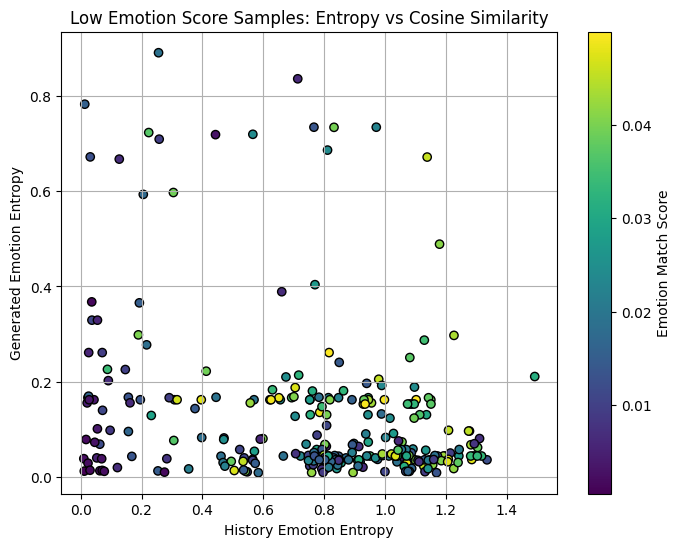

In [4]:
from scipy.stats import entropy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

low_threshold = 0.05
low_score_samples = [item for item in scored_data if 0.0 < item["emotion_match_score"] < low_threshold]

# Collect stats
gen_entropies = []
hist_entropies = []
scores = []

for item in low_score_samples:
    gen = np.array(item["generated_emotion_distribution"])
    hist = np.array(item["history_emotion_distribution"])
    gen_entropies.append(entropy(gen))
    hist_entropies.append(entropy(hist))
    scores.append(item["emotion_match_score"])

# Scatter plot of entropy vs cosine similarity
plt.figure(figsize=(8, 6))
plt.scatter(hist_entropies, gen_entropies, c=scores, cmap="viridis", edgecolors='k')
plt.colorbar(label="Emotion Match Score")
plt.xlabel("History Emotion Entropy")
plt.ylabel("Generated Emotion Entropy")
plt.title("Low Emotion Score Samples: Entropy vs Cosine Similarity")
plt.grid(True)
plt.show()


In [5]:
from pathlib import Path

input_path = Path("empathy/mistral_baseline/empathy_scores.jsonl")
output_path = Path("empathy/mistral_baseline/overall_empathy_score.jsonl")

w1 = 0.5  # weight for emotion match
w2 = 0.5  # weight for sentiment match

with input_path.open("r", encoding="utf-8") as infile, output_path.open("w", encoding="utf-8") as outfile:
    for line in tqdm(infile, desc="Scoring empathy"):
        item = json.loads(line)
        
        emotion_score = item.get("emotion_match_score", 0.0)
        sentiment_score = item.get("sentiment_match_score", 0.0)

        overall_empathy_score = w1 * emotion_score + w2 * sentiment_score
        item["overall_empathy_score"] = overall_empathy_score

        outfile.write(json.dumps(item) + "\n")

Scoring empathy: 2610it [00:00, 26655.01it/s]


In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load soft scores
with open("empathy/mistral_baseline/empathy_scores.jsonl", "r") as f:
    data = [json.loads(line) for line in f]

# Extract scores
emotion_scores = [item["emotion_match_score"] for item in data]
sentiment_scores = [item["sentiment_match_score"] for item in data]
overall_scores = [item["overall_empathy_score"] for item in data]

# Compute stats
def compute_stats(scores):
    return {
        "mean": np.mean(scores),
        "std": np.std(scores),
        "min": np.min(scores),
        "max": np.max(scores)
    }

# Collect stats
stats = {
    "emotion_match_score": compute_stats(emotion_scores),
    "sentiment_match_score": compute_stats(sentiment_scores),
    "overall_empathy_score": compute_stats(overall_scores)
}

# Print stats to console
print("--- OVERALL EMPATHY EVALUATION (SOFT EMOTIONS) ---")
print(f"Total samples: {len(data)}")
for score_type, score_stats in stats.items():
    if score_type != "total_samples":
        print(f"{score_type.replace('_', ' ').title()}:")
        print(f"  Mean: {score_stats['mean']:.4f}")
        print(f"  Std: {score_stats['std']:.4f}")
        print(f"  Min: {score_stats['min']:.4f}")
        print(f"  Max: {score_stats['max']:.4f}")
        print("")

# Save stats to a JSON file
with open("empathy/mistral_baseline/stats.json", "w") as f:
    json.dump(stats, f, indent=4)



--- OVERALL EMPATHY EVALUATION (SOFT EMOTIONS) ---
Total samples: 2610
Emotion Match Score:
  Mean: 0.5763
  Std: 0.3377
  Min: 0.0006
  Max: 1.0000

Sentiment Match Score:
  Mean: 0.6884
  Std: 0.2249
  Min: -0.2750
  Max: 1.0000

Overall Empathy Score:
  Mean: 0.6324
  Std: 0.2076
  Min: -0.0843
  Max: 1.0000



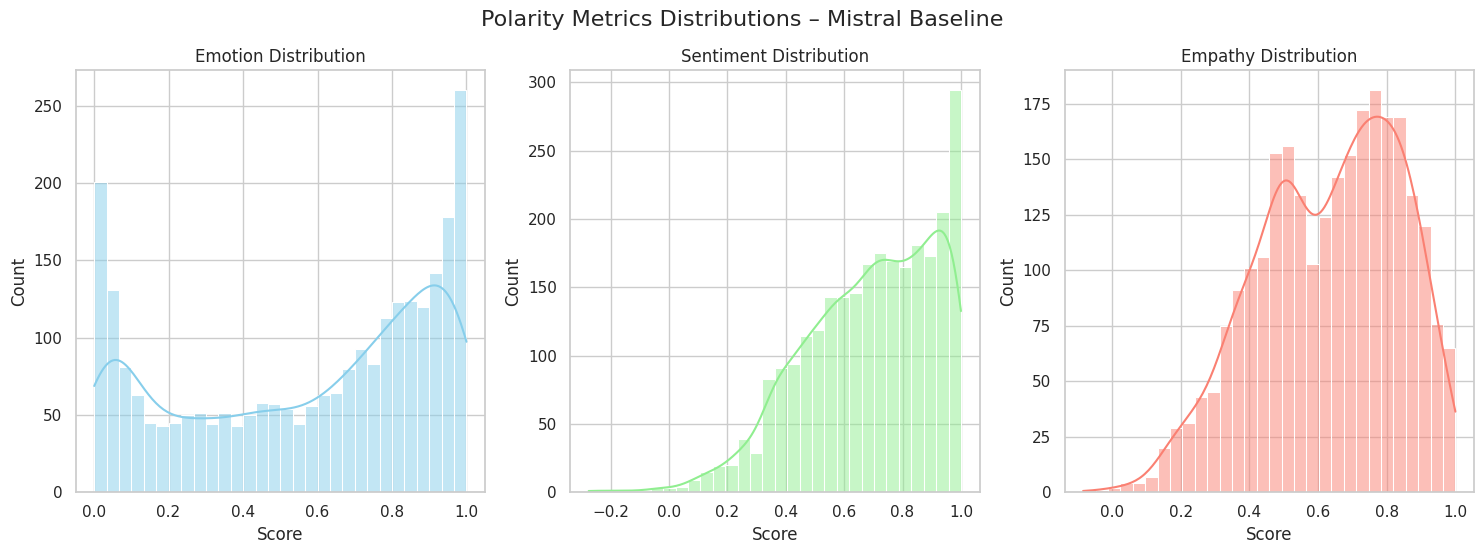

Plots saved to: empathy/mistral_baseline/plots/empathy_score_distributions.png


In [7]:
import os

# Define model name (change this for each model)
model_name = "Mistral Baseline"

# Directory to save the plots
output_dir = "empathy/mistral_baseline/plots"
os.makedirs(output_dir, exist_ok=True)

# Plotting setup
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))

# Super title indicating model
plt.suptitle(f"Polarity Metrics Distributions – {model_name}", fontsize=16, y=0.92)

# Histogram for emotion scores
plt.subplot(1, 3, 1)
sns.histplot(emotion_scores, kde=True, bins=30, color='skyblue')
plt.title("Emotion Distribution")
plt.xlabel("Score")
plt.ylabel("Count")

# Histogram for sentiment scores
plt.subplot(1, 3, 2)
sns.histplot(sentiment_scores, kde=True, bins=30, color='lightgreen')
plt.title("Sentiment Distribution")
plt.xlabel("Score")

# Histogram for overall empathy scores
plt.subplot(1, 3, 3)
sns.histplot(overall_scores, kde=True, bins=30, color='salmon')
plt.title("Empathy Distribution")
plt.xlabel("Score")

# Adjust layout to make room for suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save the figure
plot_path = os.path.join(output_dir, "empathy_score_distributions.png")
plt.savefig(plot_path)

# Show the plot
plt.show()

print(f"Plots saved to: {plot_path}")
